In [422]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [423]:
import numpy as np
import pandas as pd

In [424]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [425]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [426]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [427]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [428]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [429]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [430]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [431]:
#Execute Engine and return tuples
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()
engine.execute('SELECT * FROM Station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [432]:
#precipitation 12 month data
yeardata = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(yeardata)

#year from first year - 2017-08-23
year = dt.timedelta(days=366)
previousyear = dt.date(2017, 8, 23) - year
print(previousyear)


('2017-08-23',)
2016-08-22


In [433]:
#session query
prcp = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > previousyear).\
    order_by(Measurement.date).all()

#dataframe
prcpdf = pd.DataFrame(prcp)

# Change datatype to datetime 
prcpdf['date'] = pd.to_datetime(prcpdf['date'], format='%Y-%m-%d')
prcpdf.set_index('date', inplace=True)
prcpdf.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


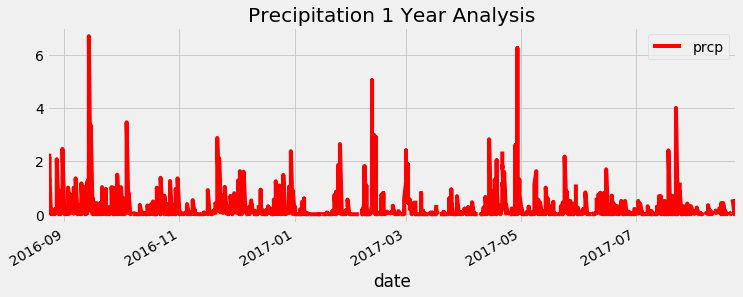

In [434]:
#Plot Results using plot method
ax = prcpdf.plot(figsize=(11,4), color="r")
ax.set_title("Precipitation 1 Year Analysis")
plt.savefig("Images/1YearAnalysis.png")
plt.show()

### Use Pandas to calcualte the summary statistics for the precipitation data



In [435]:
# Summary Statstics for Precipiation Data
prcpdf.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [436]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count() 
print(f"Available Stations - {stations} ")

Available Stations - 9 


In [437]:
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, 
func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [438]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station=stations_count[0][0]
print("The most active station is {}.".format(active_station))

The most active station is USC00519281.


In [439]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
print("          Avg         High  Low")
temp = [func.avg(Measurement.tobs),func.max(Measurement.tobs),func.min(Measurement.tobs)] 
session.query(*temp).filter(Measurement.station==active_station).all()

          Avg         High  Low


[(71.66378066378067, 85.0, 54.0)]

In [443]:
# Choose the station with the highest number of temperature observations.
temp_observations = session.query(Measurement.tobs).filter(Measurement.station==active_station).filter(Measurement.date >= year).order_by(Measurement.date.desc()).all() 
temp_observations_df = pd.DataFrame(temp_observations) 
temp_observations_df.head()


,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


In [467]:
#Confirm Count Tobs Prior to Histogram
temp_observations_count=temp_observations_df["tobs"].value_counts().reset_index().rename(columns={"index": "Temperature", "tobs": "Count"})
temp_observations_count.head()

,Temperature,Count
0,72.0,290
1,73.0,278
2,71.0,265
3,74.0,261
4,70.0,227


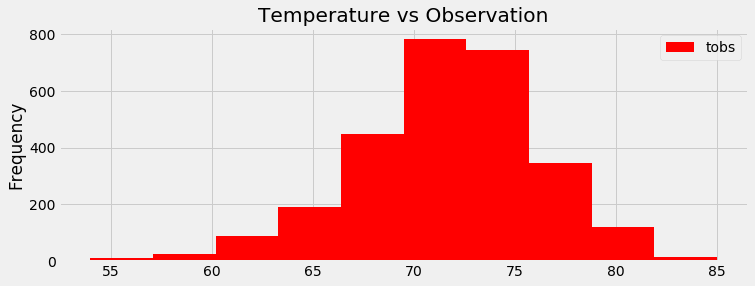

In [476]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# We need 12 bins since the observation is for twelve months
tempvsobs = temp_observations_df.plot.hist(figsize=(11,4), color="r")
tempvsobs.set_title("Temperature vs Observation")
plt.savefig("Images/TemperaturevsObservations.png")
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


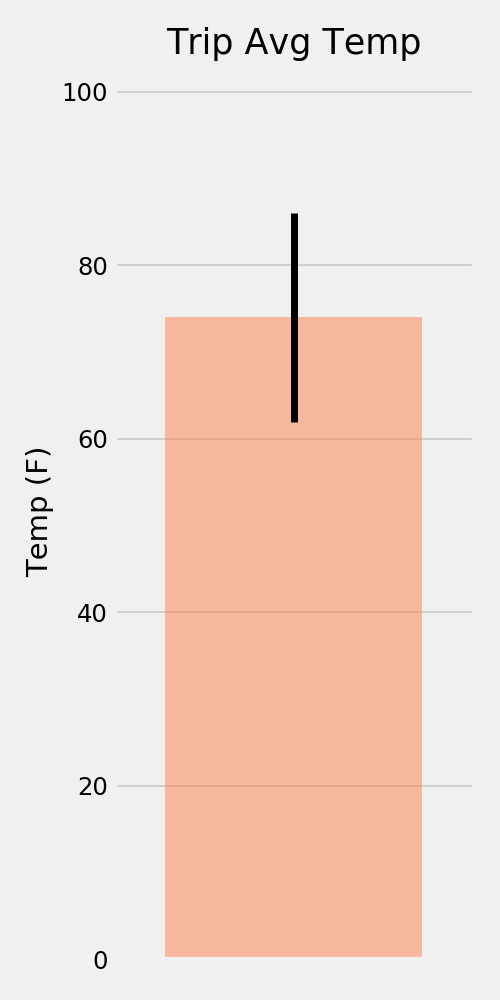

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


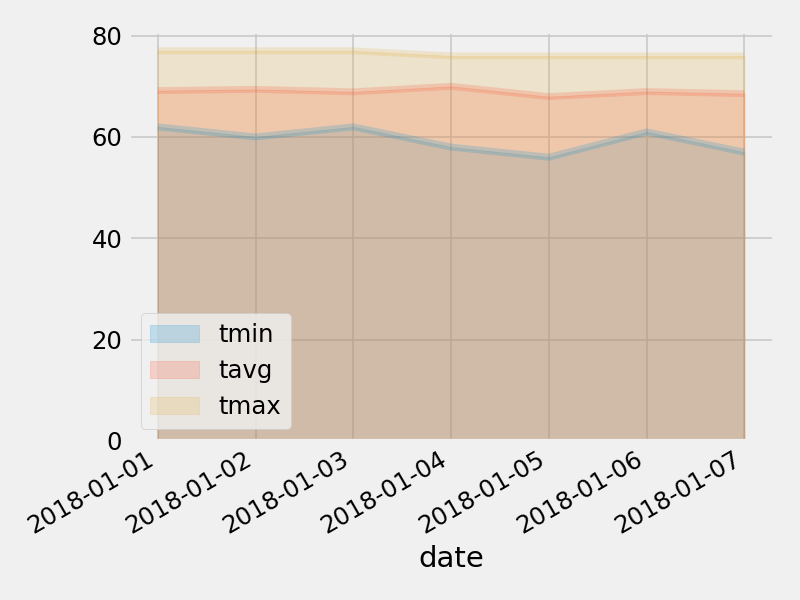

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
